# Custom CNN Architecture for Image Classification

This notebook implements and trains a custom CNN architecture from scratch.

## Objectives:
- Design custom CNN architecture
- Implement data preprocessing and augmentation
- Train the model with proper validation
- Evaluate performance and visualize results
- Save the best model

## 1. Setup and Data Loading

In [2]:
# Configure environment for Apple Silicon optimization
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Configure TensorFlow for Apple Silicon
try:
    # Enable memory growth for GPU (if available)
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU configured: {len(gpus)} device(s) found")
    else:
        print("ℹ️  No GPU found, using CPU")
except Exception as e:
    print(f"⚠️  GPU configuration warning: {e}")

print(f"TensorFlow version: {tf.__version__}")
print(f"Available devices: {[device.name for device in tf.config.list_physical_devices()]}")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
print("✅ Random seeds set for reproducibility")

✅ GPU configured: 1 device(s) found
TensorFlow version: 2.15.0
Available devices: ['/physical_device:CPU:0', '/physical_device:GPU:0']
✅ Random seeds set for reproducibility


## 2. Data Loading and Preprocessing

In [3]:
path = '/Users/smithn5/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2'

In [4]:
# Load the dataset using tf.keras.preprocessing.image.ImageDataGenerator
batch_size = 32
img_height = 224 # to work with vgg16 models
img_width = 224 # to work with vgg16 models

img_height = 32 # for basic cnn
img_width = 32 # for basic cnn


# ISSUE DIAGNOSIS: Your augmentation might be too aggressive!
# Let's create a less aggressive augmentation setup

print("🔧 Creating improved data generators...")

# Create LESS aggressive augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1/255,  # Normalize to [0,1]
    rotation_range=10,      # Reduced from 20
    width_shift_range=0.2,  # Reduced from 0.2
    height_shift_range=0.2, # Reduced from 0.2
    shear_range=0.2,        # Reduced from 0.2
    zoom_range=0.2,         # Reduced from 0.2
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

# Create validation generator without augmentation (IMPORTANT!)
val_datagen = ImageDataGenerator(
    rescale=1/255,  # Only rescaling for validation
    validation_split=0.1
)

# Create training dataset with augmentation
train_ds = train_datagen.flow_from_directory(
    os.path.join(path, 'raw-img'),
    subset="training",
    shuffle=True,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Create validation dataset WITHOUT augmentation
val_ds = val_datagen.flow_from_directory(
    os.path.join(path, 'raw-img'),
    subset="validation",
    shuffle=False,  # Don't shuffle validation
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Get class names from the dataset
class_names = list(train_ds.class_indices.keys())
print(f"Found {len(class_names)} classes: {class_names}")

# Calculate dataset sizes
print(f"Training samples: {train_ds.samples}")
print(f"Validation samples: {val_ds.samples}")
print(f"Training batches per epoch: {len(train_ds)}")
print(f"Validation batches per epoch: {len(val_ds)}")
print(f"Batch size: {batch_size}")

# Verify class balance
print(f"\nClass distribution check:")
class_counts = {}
for class_name in class_names:
    class_dir = os.path.join(path, 'raw-img', class_name)
    if os.path.exists(class_dir):
        count = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        class_counts[class_name] = count
        print(f"  {class_name}: {count} images")

# Check for extremely imbalanced classes
min_count = min(class_counts.values())
max_count = max(class_counts.values())
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
print(f"\nClass balance analysis:")
print(f"  Min class size: {min_count}")
print(f"  Max class size: {max_count}")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio > 10:
    print("⚠️  WARNING: Severe class imbalance detected!")
    print("   This could explain poor learning performance")
elif imbalance_ratio > 3:
    print("⚡ Moderate class imbalance detected")
else:
    print("✅ Classes are reasonably balanced")

print(f"\n✅ Improved data generators created with:")
print(f"  - Reduced augmentation intensity")
print(f"  - Separate validation generator (no augmentation)")
print(f"  - Proper class balance verification")

🔧 Creating improved data generators...
Found 23565 images belonging to 10 classes.
Found 2614 images belonging to 10 classes.
Found 10 classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Training samples: 23565
Validation samples: 2614
Training batches per epoch: 737
Validation batches per epoch: 82
Batch size: 32

Class distribution check:
  cane: 4863 images
  cavallo: 2623 images
  elefante: 1446 images
  farfalla: 2112 images
  gallina: 3098 images
  gatto: 1668 images
  mucca: 1866 images
  pecora: 1820 images
  ragno: 4821 images
  scoiattolo: 1862 images

Class balance analysis:
  Min class size: 1446
  Max class size: 4863
  Imbalance ratio: 3.36
⚡ Moderate class imbalance detected

✅ Improved data generators created with:
  - Reduced augmentation intensity
  - Separate validation generator (no augmentation)
  - Proper class balance verification


## 3. Custom CNN Architecture Design

In [ ]:
# Build custom CNN model based on VGG16 architecture
# AT THE MOMENT THIS SUCKS AND GIVE 0.4 ACCURACY AFTER RUNNUNG FOR A WHILE
# def create_custom_vgg16_cnn(input_shape, num_classes):
#     """
#     Create a custom CNN following VGG16 architecture.
    
#     Architecture: 5 convolutional blocks + Global Average Pooling + Dense layers
#     """
#     model = models.Sequential([
#         # Input layer
#         layers.Input(shape=input_shape),
        
#         # Block 1 - 64 filters
#         layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1'),
#         layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2'),
#         layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'),
        
#         # Block 2 - 128 filters
#         layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1'),
#         layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'),
#         layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'),
        
#         # Block 3 - 256 filters
#         layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'),
#         layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'),
#         layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'),
#         layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'),
        
#         # Block 4 - 512 filters
#         layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1'),
#         layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2'),
#         layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3'),
#         layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'),
        
#         # Block 5 - 512 filters
#         layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1'),
#         layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2'),
#         layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3'),
        
#         # Classification head (replacing VGG16's fully connected layers)
#         layers.GlobalAveragePooling2D(),
#         layers.Dense(512, activation='relu'),
#         layers.Dense(num_classes, activation='softmax')
#     ])
    
#     return model

# # Create the model
# input_shape = (img_height, img_width, 3)  # (224, 224, 3) for VGG16-like input
# num_classes = len(class_names)
# custom_model = create_custom_vgg16_cnn(input_shape, num_classes)

# # Display model architecture
# custom_model.summary()

# print(f"\nModel Details:")
# print(f"Input shape: {input_shape}")
# print(f"Number of classes: {num_classes}")
# print(f"Total parameters: {custom_model.count_params():,}")
# print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in custom_model.trainable_weights]):,}")

# # Visualize model architecture
# tf.keras.utils.plot_model(
#     custom_model, 
#     to_file='../models/custom_vgg16_architecture.png',
#     show_shapes=True,
#     show_layer_names=True,
#     rankdir='TB'
# )
# print("✅ Model architecture diagram saved to '../models/custom_vgg16_architecture.png'")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [5]:
def create_simple_cnn(input_shape, num_classes):
    """
    Create a simple CNN model.
    """
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Create the model
input_shape = (img_height, img_width, 3)
num_classes = len(class_names)
custom_model = create_simple_cnn(input_shape, num_classes)

# Display model architecture
custom_model.summary()

print(f"\nModel Details:")
print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")
print(f"Total parameters: {custom_model.count_params():,}")
print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in custom_model.trainable_weights]):,}")

# Visualize model architecture
tf.keras.utils.plot_model(
    custom_model,
    to_file='../models/simple_cnn_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB'
)
print("✅ Model architecture diagram saved to '../models/simple_cnn_architecture.png'")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)         0

## 4. Model Compilation and Training Setup

In [12]:
# Let's first debug the data and model setup
print("🔍 DEBUGGING MODEL AND DATA...")
print("="*50)

# Check data generators
print("Data Generator Check:")
print(f"Training samples: {train_ds.samples}")
print(f"Validation samples: {val_ds.samples}")
print(f"Classes found: {len(class_names)}")
print(f"Class names: {class_names}")

# Test a batch to see if data looks correct
sample_batch_x, sample_batch_y = next(train_ds)
print(f"\nSample batch shapes:")
print(f"Images: {sample_batch_x.shape}")
print(f"Labels: {sample_batch_y.shape}")
print(f"Image value range: [{sample_batch_x.min():.3f}, {sample_batch_x.max():.3f}]")
print(f"Labels sum (should be 1 for each): {sample_batch_y.sum(axis=1)[:5]}")
train_ds.reset()

# Check model output
print(f"\nModel check:")
print(f"Model expects input shape: {custom_model.input_shape}")
print(f"Model outputs shape: {custom_model.output_shape}")
print(f"Number of parameters: {custom_model.count_params():,}")

# Test model prediction on one batch
test_pred = custom_model.predict(sample_batch_x[:1], verbose=0)
print(f"Test prediction shape: {test_pred.shape}")
print(f"Test prediction sum: {test_pred.sum()} (should be ~1.0)")
print(f"Test prediction values: {test_pred[0][:5]}...")

print("\n" + "="*50)
print("🚀 STARTING IMPROVED TRAINING...")
print("="*50)

# SOLUTION 1: Lower learning rate significantly
custom_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Much lower LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("✅ Reduced learning rate to 0.0001")

# SOLUTION 2: Improved callbacks with more aggressive learning rate reduction
improved_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,  # Reduced patience
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        '../models/custom_simple_animals10_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,  # More aggressive reduction
        patience=5,  # slower response
        min_lr=1e-8,
        verbose=1
    )
]


🔍 DEBUGGING MODEL AND DATA...
Data Generator Check:
Training samples: 23565
Validation samples: 2614
Classes found: 10
Class names: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']

Sample batch shapes:
Images: (32, 32, 32, 3)
Labels: (32, 10)
Image value range: [0.000, 1.000]
Labels sum (should be 1 for each): [1. 1. 1. 1. 1.]

Model check:
Model expects input shape: (None, 32, 32, 3)
Model outputs shape: (None, 10)
Number of parameters: 356,810
Test prediction shape: (1, 10)
Test prediction sum: 1.0000001192092896 (should be ~1.0)
Test prediction values: [0.21279405 0.06999987 0.14103147 0.00464242 0.06450798]...

🚀 STARTING IMPROVED TRAINING...
✅ Reduced learning rate to 0.0001


## 5. Model Training

In [13]:

# Training parameters
EPOCHS = 35  # Increased epochs since we lowered LR

print(f"Improved training setup:")
print(f"- Learning rate: 0.0001 (reduced from 0.001)")
print(f"- Max epochs: {EPOCHS}")
print(f"- Early stopping patience: 8")
print(f"- LR reduction factor: 0.2 (more aggressive)")
print(f"- Batch size: {batch_size}")

# Train with improved settings
history = custom_model.fit(
    train_ds,
    steps_per_epoch=len(train_ds),
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=len(val_ds),
    callbacks=improved_callbacks,
    verbose=1
)

print("\n✅ Training completed!")
if len(history.history['accuracy']) > 0:
    print(f"Total epochs trained: {len(history.history['accuracy'])}")
    print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
    print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")


# Reset generators for future use
train_ds.reset()
val_ds.reset()

Improved training setup:
- Learning rate: 0.0001 (reduced from 0.001)
- Max epochs: 35
- Early stopping patience: 8
- LR reduction factor: 0.2 (more aggressive)
- Batch size: 32
Epoch 1/35


2025-10-23 20:33:59.257236: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


737/737 [==============================] - ETA: 0s - loss: 1.6848 - accuracy: 0.4124
Epoch 1: val_accuracy improved from -inf to 0.40513, saving model to ../models/custom_simple_animals10_best.h5
737/737 [==============================] - 25s 33ms/step - loss: 1.6848 - accuracy: 0.4124 - val_loss: 1.7044 - val_accuracy: 0.4051 - lr: 1.0000e-04
Epoch 2/35
737/737 [==============================] - ETA: 0s - loss: 1.6472 - accuracy: 0.4295
Epoch 2: val_accuracy did not improve from 0.40513
737/737 [==============================] - 24s 33ms/step - loss: 1.6472 - accuracy: 0.4295 - val_loss: 1.8739 - val_accuracy: 0.3707 - lr: 1.0000e-04
Epoch 3/35
736/737 [============================>.] - ETA: 0s - loss: 1.6144 - accuracy: 0.4405
Epoch 3: val_accuracy did not improve from 0.40513
737/737 [==============================] - 24s 32ms/step - loss: 1.6148 - accuracy: 0.4406 - val_loss: 1.8963 - val_accuracy: 0.3768 - lr: 1.0000e-04
Epoch 4/35
737/737 [==============================] - ETA: 0

## 6. Training History Visualization

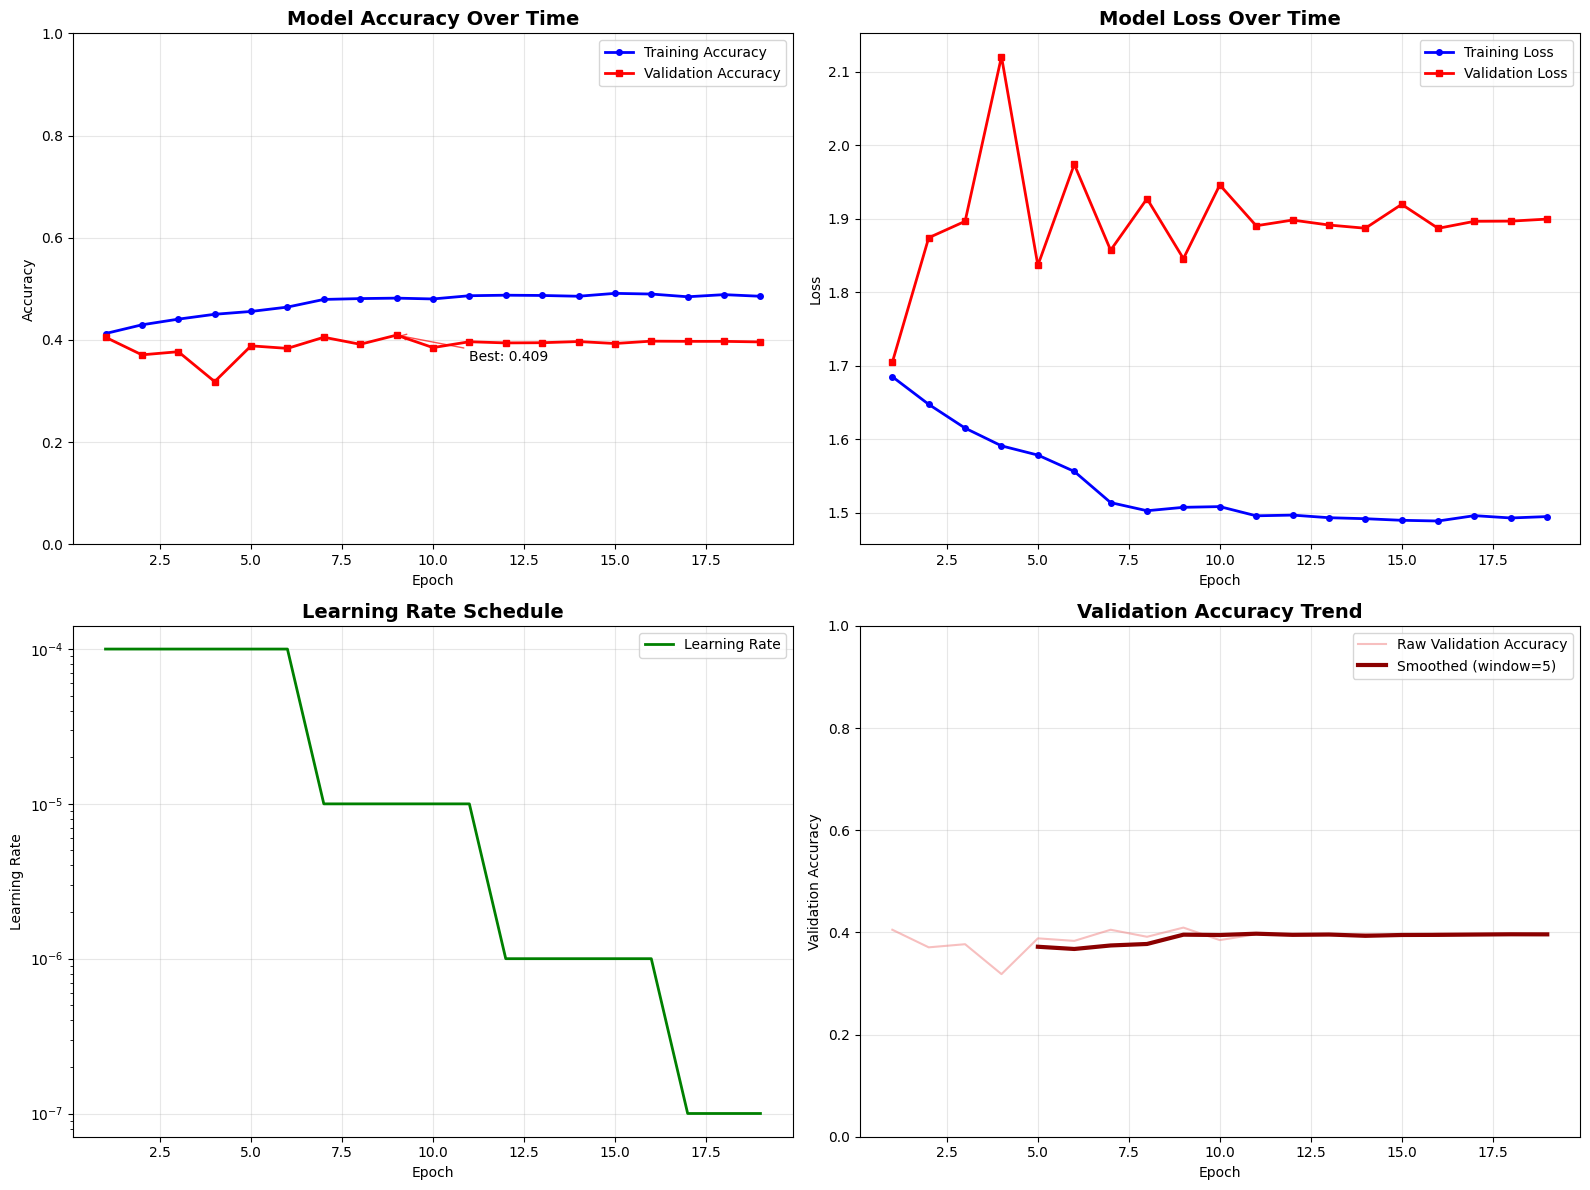


TRAINING HISTORY ANALYSIS
Total epochs trained: 19
Best validation accuracy: 0.4093 at epoch 9
Final training accuracy: 0.4853
Final validation accuracy: 0.3959
Best validation loss: 1.7044
Final validation loss: 1.8993

Overfitting Analysis:
Final accuracy gap: 0.0894
⚡ Mild overfitting (gap > 0.05)
Validation accuracy stability (last 5 epochs std): 0.0017
✅ Training converged well


In [14]:
def plot_training_history(history):
    """
    Plot training and validation metrics with enhanced visualizations.
    """
    # Create a larger figure with more subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot accuracy
    epochs = range(1, len(history.history['accuracy']) + 1)
    ax1.plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2, marker='o', markersize=4)
    ax1.plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
    ax1.set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])
    
    # Add best accuracy annotation
    best_val_acc = max(history.history['val_accuracy'])
    best_val_acc_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    ax1.annotate(f'Best: {best_val_acc:.3f}', 
                xy=(best_val_acc_epoch, best_val_acc), 
                xytext=(best_val_acc_epoch + 2, best_val_acc - 0.05),
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.7))
    
    # Plot loss
    ax2.plot(epochs, history.history['loss'], 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
    ax2.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)
    ax2.set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot learning rate (if available)
    if 'lr' in history.history:
        ax3.plot(epochs, history.history['lr'], 'g-', label='Learning Rate', linewidth=2)
        ax3.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate')
        ax3.set_yscale('log')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    else:
        # Plot accuracy difference (overfitting indicator)
        acc_diff = np.array(history.history['accuracy']) - np.array(history.history['val_accuracy'])
        ax3.plot(epochs, acc_diff, 'purple', label='Training - Validation Accuracy', linewidth=2)
        ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax3.set_title('Overfitting Indicator', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Accuracy Difference')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # Plot smoothed validation accuracy trend
    if len(history.history['val_accuracy']) > 5:
        # Simple moving average
        window_size = min(5, len(history.history['val_accuracy']) // 3)
        val_acc_smooth = np.convolve(history.history['val_accuracy'], 
                                   np.ones(window_size)/window_size, mode='valid')
        smooth_epochs = range(window_size, len(history.history['val_accuracy']) + 1)
        
        ax4.plot(epochs, history.history['val_accuracy'], 'lightcoral', alpha=0.5, label='Raw Validation Accuracy')
        ax4.plot(smooth_epochs, val_acc_smooth, 'darkred', linewidth=3, label=f'Smoothed (window={window_size})')
        ax4.set_title('Validation Accuracy Trend', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Validation Accuracy')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        ax4.set_ylim([0, 1])
    else:
        # If not enough epochs, show final metrics summary
        ax4.text(0.1, 0.8, 'Training Summary', fontsize=16, fontweight='bold', transform=ax4.transAxes)
        ax4.text(0.1, 0.6, f'Epochs: {len(epochs)}', fontsize=12, transform=ax4.transAxes)
        ax4.text(0.1, 0.5, f'Best Val Acc: {best_val_acc:.4f}', fontsize=12, transform=ax4.transAxes)
        ax4.text(0.1, 0.4, f'Final Train Acc: {history.history["accuracy"][-1]:.4f}', fontsize=12, transform=ax4.transAxes)
        ax4.text(0.1, 0.3, f'Final Val Acc: {history.history["val_accuracy"][-1]:.4f}', fontsize=12, transform=ax4.transAxes)
        ax4.set_xlim(0, 1)
        ax4.set_ylim(0, 1)
        ax4.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print comprehensive metrics
    print("\n" + "="*60)
    print("TRAINING HISTORY ANALYSIS")
    print("="*60)
    print(f"Total epochs trained: {len(epochs)}")
    print(f"Best validation accuracy: {best_val_acc:.4f} at epoch {best_val_acc_epoch}")
    print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Best validation loss: {min(history.history['val_loss']):.4f}")
    print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")
    
    # Calculate overfitting metrics
    final_gap = history.history['accuracy'][-1] - history.history['val_accuracy'][-1]
    print(f"\nOverfitting Analysis:")
    print(f"Final accuracy gap: {final_gap:.4f}")
    if final_gap > 0.1:
        print("⚠️  Potential overfitting detected (gap > 0.1)")
    elif final_gap > 0.05:
        print("⚡ Mild overfitting (gap > 0.05)")
    else:
        print("✅ Good generalization (gap ≤ 0.05)")
    
    # Training stability
    last_5_val_acc = history.history['val_accuracy'][-5:] if len(history.history['val_accuracy']) >= 5 else history.history['val_accuracy']
    val_acc_std = np.std(last_5_val_acc)
    print(f"Validation accuracy stability (last 5 epochs std): {val_acc_std:.4f}")
    
    if val_acc_std < 0.01:
        print("✅ Training converged well")
    elif val_acc_std < 0.02:
        print("⚡ Training mostly stable")
    else:
        print("⚠️  Training still fluctuating")
    
    print("="*60)

# Plot the training history
plot_training_history(history)

## 7. Model Evaluation on Test Set

In [15]:
# Evaluate on validation set (since we don't have a separate test set)
val_ds.reset()
val_loss, val_accuracy = custom_model.evaluate(val_ds, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# Generate predictions on validation set
print("Generating predictions...")
val_ds.reset()
y_pred = custom_model.predict(val_ds, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels from validation generator
val_ds.reset()
y_true_classes = []
for i in range(len(val_ds)):
    batch_images, batch_labels = next(val_ds)
    batch_true_classes = np.argmax(batch_labels, axis=1)
    y_true_classes.extend(batch_true_classes)

y_true_classes = np.array(y_true_classes)

# Ensure we have the same number of predictions and true labels
min_length = min(len(y_pred_classes), len(y_true_classes))
y_pred_classes = y_pred_classes[:min_length]
y_true_classes = y_true_classes[:min_length]

print(f"Number of samples evaluated: {min_length}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Reset generator
val_ds.reset()

Validation Accuracy: 0.4093
Validation Loss: 1.8455
Generating predictions...


82/82 [==============================] - 2s 18ms/step
Number of samples evaluated: 2614

Classification Report:
              precision    recall  f1-score   support

        cane       0.69      0.24      0.36       486
     cavallo       0.41      0.50      0.45       262
    elefante       0.63      0.25      0.36       144
    farfalla       0.25      0.90      0.39       211
     gallina       0.38      0.44      0.41       309
       gatto       0.62      0.03      0.06       166
       mucca       0.36      0.19      0.25       186
      pecora       0.38      0.32      0.35       182
       ragno       0.54      0.69      0.60       482
  scoiattolo       0.47      0.17      0.25       186

    accuracy                           0.41      2614
   macro avg       0.47      0.37      0.35      2614
weighted avg       0.49      0.41      0.38      2614



## 8. Confusion Matrix Visualization

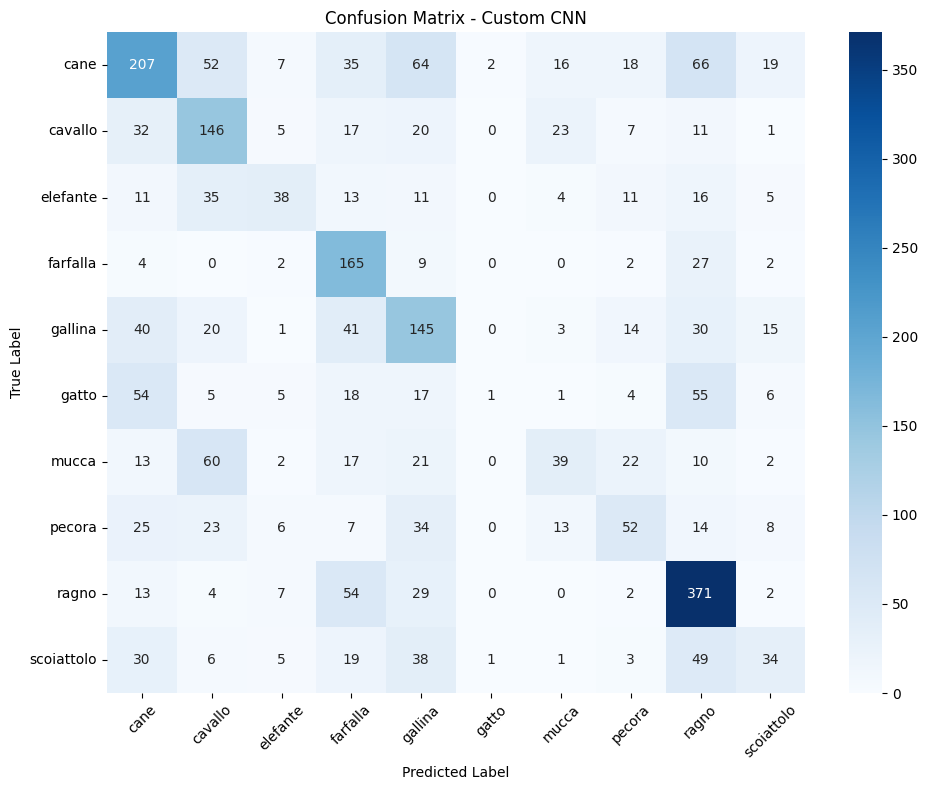


Per-class Accuracy:
cane: 0.4259
cavallo: 0.5573
elefante: 0.2639
farfalla: 0.7820
gallina: 0.4693
gatto: 0.0060
mucca: 0.2097
pecora: 0.2857
ragno: 0.7697
scoiattolo: 0.1828


In [13]:
# Generate and plot confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Custom CNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {class_accuracy[i]:.4f}")

## 9. Model Saving and Results Summary

In [16]:
# model accuracy saving and documentation
val_accuracy_str = f"{val_accuracy:.2f}".replace('.', '_')
# Save the final model
model_filename = f'../models/custom_costum_animals10_acc_{val_accuracy_str}.h5'
custom_model.save(model_filename)
print(f"Model saved as: {model_filename}")

# Save training history
import pickle
with open(f'../models/custom_costum_animals10_acc_{val_accuracy_str}_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print(f"Training history saved")

# Save model configuration
model_config = {
    'model_name': 'Custom CNN',
    'dataset': 'Animals10',
    'input_shape': input_shape,
    'num_classes': num_classes,
    'batch_size': batch_size,
    'epochs_trained': len(history.history['accuracy']),
    'best_val_accuracy': max(history.history['val_accuracy']),
    'final_val_accuracy': val_accuracy,
    'total_parameters': custom_model.count_params(),
    'architecture': 'VGG16-inspired with Global Average Pooling'
}

import json
with open(f'../models/custom_costum_animals10_acc_{val_accuracy_str}_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)

# Results summary
print("\n" + "="*60)
print("CUSTOM CNN RESULTS SUMMARY")
print("="*60)
print(f"Dataset: Animals10")
print(f"Architecture: Custom CNN with {custom_model.count_params():,} parameters")
print(f"Input shape: {input_shape}")
print(f"Training epochs: {len(history.history['accuracy'])}")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Final validation accuracy: {val_accuracy:.4f}")
print(f"Model saved: {model_filename}")
print(f"Architecture follows CNN pattern:")
print(f"  - 5 convolutional blocks (64→128→256→512→512 filters)")
print(f"  - Global Average Pooling instead of FC layers")
print(f"  - Dense(512) + Dense({num_classes}) classifier")
print("="*60)

Model saved as: ../models/custom_costum_animals10_acc_0_41.h5
Training history saved

CUSTOM CNN RESULTS SUMMARY
Dataset: Animals10
Architecture: Custom CNN with 356,810 parameters
Input shape: (32, 32, 3)
Training epochs: 19
Best validation accuracy: 0.4093
Final validation accuracy: 0.4093
Model saved: ../models/custom_costum_animals10_acc_0_41.h5
Architecture follows CNN pattern:
  - 5 convolutional blocks (64→128→256→512→512 filters)
  - Global Average Pooling instead of FC layers
  - Dense(512) + Dense(10) classifier
